In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression, LinearRegression, Lasso
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, mean_absolute_percentage_error

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LogisticRegression, LinearRegression, Lasso
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from catboost import CatBoostClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures

ModuleNotFoundError: No module named 'numpy'

In [5]:
df = pd.read_excel('train.xlsx')

In [6]:
df = df.drop(['Unnamed: 0', '№ брони','Способ оплаты'], axis=1)
df['В какой час бронировали'] = (df['Дата бронирования'].dt.hour + 2) % 24
df['За сколько часов до заезда бронь'] = (df['Заезд'] - df['Дата бронирования']).dt.total_seconds() // 3600 #насколько рано бронь
df = df.drop(['Дата бронирования', 'Заезд','Выезд'], axis=1) # уберем ненужные столбцы


for col in ['Источник']:
    df = pd.concat([df, pd.get_dummies(df[col])], axis=1)
    df = df.drop(col, axis=1)
df['Бронь с официального сайта'] = df['Официальный сайт']
df['Бронь со специальных сайтов'] = df['Bronevik.com(new)'] + df['booking.com'] + df['Бронирование из экстранета'] + df['Zabroniryi.ru'] + df['OneTwoTrip'] + df['ostrovok.ru']  + df['booking.com (Booking.com)']+ df['Acase.ru (ООО "АКАДЕМ-ОНЛАЙН")']+ df['Acase.ru (ООО "ПРАНДИУМ")']+ df['Alean.ru (13.10.2023-02.06.2025)']+ df['Alean.ru (03.02.2022-31.01.2023)']+ df['101hotels.com']+ df['Acase.ru (ООО "КАЛЕЙДОСКОП")']+ df['Otello'] + df['expedia.com (A-Hotels.com)']+ df['Alean.ru (31.10.2023-22.06.2025)'] + df['Svoy Hotel']+ df['Alean.ru (20.01.2021-31.01.2022)']
df['Бронь по лояльности'] = df['Программа лояльности'] + df['Cuva']
df['Бронь с гигантов'] = df['Яндекс.Путешествия'] + df['Тинькофф Путешествия'] + df['Ozon'] + df['ВКонтакте']

for col in ['Яндекс.Путешествия', 'Официальный сайт', 'Bronevik.com(new)',
       'booking.com', 'Бронирование из экстранета', 'Zabroniryi.ru',
       'OneTwoTrip', 'ostrovok.ru', 'Программа лояльности', 'Cuva',
       'booking.com (Booking.com)', 'Acase.ru (ООО "АКАДЕМ-ОНЛАЙН")',
       'Acase.ru (ООО "ПРАНДИУМ")', 'Alean.ru (13.10.2023-02.06.2025)',
       'Alean.ru (03.02.2022-31.01.2023)', '101hotels.com',
       'Acase.ru (ООО "КАЛЕЙДОСКОП")', 'Alean.ru (16.01.2023-06.09.2024)',
       'Bronevik.com/Bro.Online', 'Тинькофф Путешествия', 'ВКонтакте',
       'Otello', 'expedia.com (A-Hotels.com)', 'Ozon',
       'Alean.ru (31.10.2023-22.06.2025)', 'Svoy Hotel',
       'Alean.ru (20.01.2021-31.01.2022)']:
    df = df.drop(col, axis=1)


df['Факт отмены'] = (df['Статус брони'] != 'Активный').astype(int)
#df = df[df['Статус брони'] != 'Неподтвержденные']
#df.loc[df['Дата отмены'].isna(), 'Факт отмены'] = 0
#df.loc[df['Дата отмены'].notna(),'Факт отмены'] = 1
df = df.drop(['Дата отмены', 'Статус брони'], axis=1)

#df = df[df['Стоимость'] > 1000]

categories = np.array(['Номер «Стандарт»', 'Номер «Студия»', 'Номер «Люкс»',
       'Апартаменты с 2 спальнями с отдельным входом',
       'Коттедж с 3 спальнями',
       'Коттедж с 2 спальнями',
       'Номер «Стандарт» для маломобильных групп населения'])

# Create new columns with all zeros
for cat in categories:
    df[cat] = 0

for index, row in df.iterrows():
    for cat in categories:
        if cat in row['Категория номера']:
            df.loc[index, cat] = 1  # Set the value to 1 if category is present

for col in ['Категория номера']:
    df = df.drop(col, axis=1)

df

,Номеров,Стоимость,Внесена предоплата,Ночей,Гостей,Гостиница,В какой час бронировали,За сколько часов до заезда бронь,Бронь с официального сайта,Бронь со специальных сайтов,Бронь по лояльности,Бронь с гигантов,Факт отмены,Номер «Стандарт»,Номер «Студия»,Номер «Люкс»,Апартаменты с 2 спальнями с отдельным входом,Коттедж с 3 спальнями,Коттедж с 2 спальнями,Номер «Стандарт» для маломобильных групп населения
0,1,25700.0,0,3,2,1,22,186.0,False,False,False,True,1,1,0,0,0,0,0,0
1,1,24800.0,12400,2,2,1,16,552.0,True,False,False,False,0,1,0,0,0,0,0,0
2,1,25800.0,12900,2,2,4,0,472.0,True,False,False,False,0,0,1,0,0,0,0,0
3,1,10500.0,0,1,1,3,17,239.0,False,True,False,False,0,1,0,0,0,0,0,0
4,1,28690.0,28690,2,4,1,21,211.0,True,False,False,False,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26169,1,18240.0,9120,2,2,2,19,1485.0,True,False,False,False,0,1,0,0,0,0,0,0
26170,1,69600.0,23200,3,3,4,19,117.0,True,False,False,False,0,0,1,0,0,0,0,0
26171,1,55600.0,13900,4,2,2,21,1123.0,True,False,False,False,0,1,0,0,0,0,0,0
26172,1,6300.0,0,1,2,3,11,1613.0,False,True,False,False,1,1,0,0,0,0,0,0


In [36]:
percentage_cancelled = (df[(df['Факт отмены'] == 1) & (df['Бронь со специальных сайтов'] == True)].shape[0] / 
                        df[df['Бронь с официального сайта'] == True].shape[0]) * 100

print(f'Процент отказавшихся пользователей: {percentage_cancelled:.2f}%')

Процент отказавшихся пользователей: 5.42%


In [9]:
percentage_cancelled = (df[(df['Факт отмены'] == 1) & (df['Бронь с гигантов'] == True)].shape[0] / 
                        df[df['Бронь с официального сайта'] == True].shape[0]) * 100

print(f'Процент отказавшихся пользователей: {percentage_cancelled:.2f}%')

Процент отказавшихся пользователей: 1.99%


In [10]:
g = df[(df['Бронь с официального сайта'] == True)].shape[0]

print(g)

21077


In [14]:
g = df[(df['Бронь со специальных сайтов'] == True)].shape[0]

print(g)

3266


In [15]:
g = df[(df['Бронь с гигантов'] == True)].shape[0]

print(g)

1148


In [17]:
g = df[(df['Бронь по лояльности'] == True)].shape[0]

print(g)

652


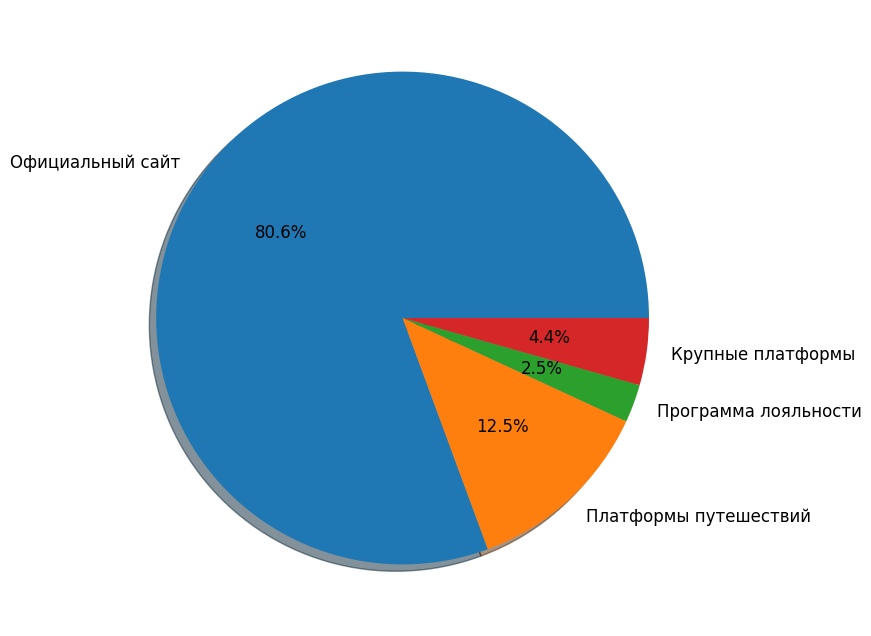

In [54]:
# предположим, что у вас есть список значений для каждого сектора графика
values = [21077, 3266,652,1148]  # процент отказов на официальном сайте и на платформах типа Яндекса
labels = ['Официальный сайт', 'Платформы путешествий','Программа лояльности','Крупные платформы']

# создаем график pie
plt.figure(figsize=(10, 8))
plt.pie(values, labels=labels,shadow=True, textprops={'size': '12'}, autopct='%1.1f%%')

# отображаем график
plt.savefig("hhjgh.png")

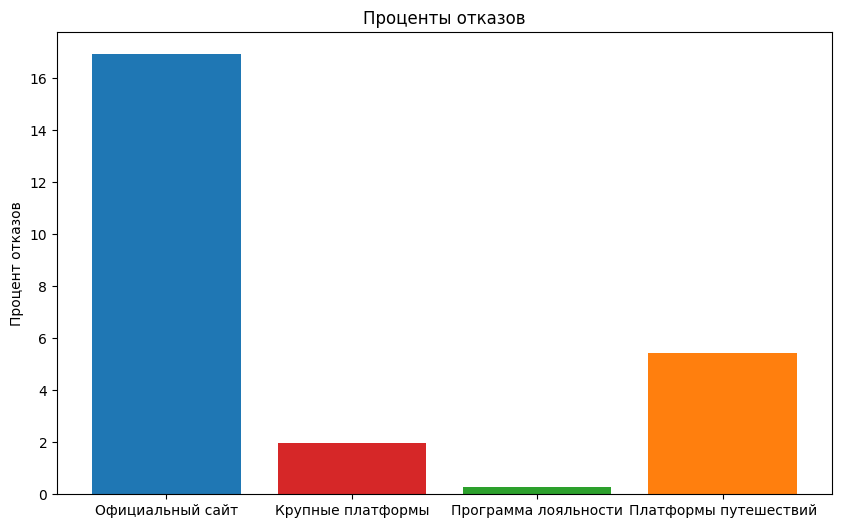

In [53]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
values = [16.93, 1.99, 0.27, 5.42]
labels = ['Официальный сайт', 'Крупные платформы', 'Программа лояльности', 'Платформы путешествий']

# список цветов для каждого столбца
colors = ['#1f77b4', '#d62728', '#2ca02c', '#ff7f0e']

plt.bar(labels, values, color=colors)
plt.ylabel('Процент отказов')
plt.title('Проценты отказов')

plt.savefig("hhjgh22222222222.png")

In [ ]:
sns.distplot(len_df[df_dedupped["text_type"] == "spam"]["len_chars"], bins = 20, ax = ax[0, 0], color = 'crimson')
ax[0, 0].set_xlabel("Длина сообщений в символах у spam")
ax[0, 0].set_ylabel("")

sns.distplot(len_df[df_dedupped["text_type"] == "ham"]["len_chars"], bins = 20, ax = ax[0, 1], color = 'crimson')
ax[0, 1].set_xlabel("Длина сообщений в символах у ham")
ax[0, 1].set_ylabel("")


sns.distplot(len_df[df_dedupped["text_type"] == "spam"]["len_words"], bins = 20, ax = ax[1, 0], color = 'g')
ax[1, 0].set_xlabel("Длина сообщений в словах у spam")
ax[1, 0].set_ylabel("")

sns.distplot(len_df[df_dedupped["text_type"] == "ham"]["len_words"], bins = 20, ax = ax[1, 1], color = 'g')
ax[1, 1].set_xlabel("Длина сообщений в словах у ham")
ax[1, 1].set_ylabel("")


sns.distplot(len_df[df_dedupped["text_type"] == "spam"]["len_sentences"], bins = 20, ax = ax[2, 0], color = 'dodgerblue')
ax[2, 0].set_xlabel("Длина сообщений в предложениях у spam")
ax[2, 0].set_ylabel("")
ax[2, 0].set_xlim(0,6)

sns.distplot(len_df[df_dedupped["text_type"] == "ham"]["len_sentences"], bins = 20, ax = ax[2, 1], color = 'dodgerblue')
ax[2, 1].set_xlabel("Длина сообщений в предложениях у ham")
ax[2, 1].set_ylabel("")
ax[2, 1].set_xlim(0,6);

plt.show()

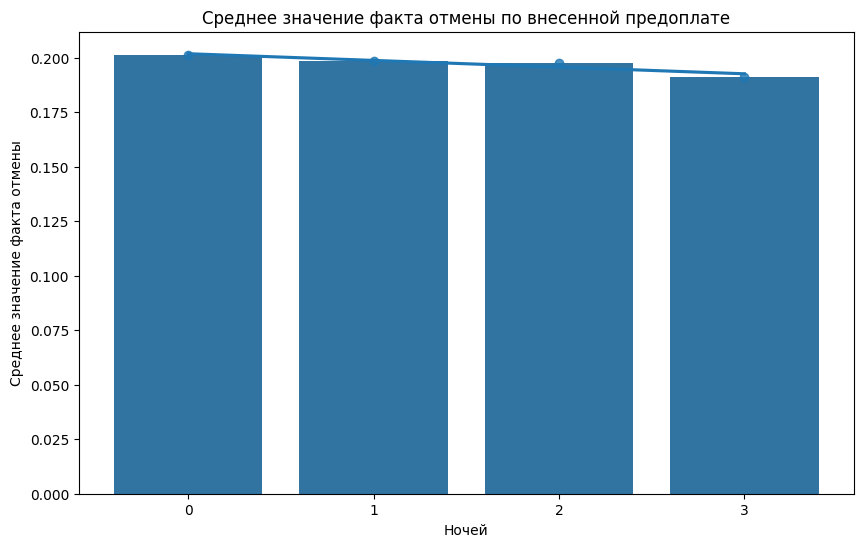

In [62]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# assume df is your DataFrame with approximately 26,000 rows

# sort the data by "Внесена предоплата" column
df_sorted = df.sort_values(by="Ночей")

# create a new DataFrame with the aggregated data
aggregated_df = df_sorted.groupby(df_sorted.index // 8000).mean()["Факт отмены"].reset_index()

# rename the columns for clarity
aggregated_df.columns = ["Ночей", "Среднее значение факта отмены"]

# create the bar chart with seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x="Ночей", y="Среднее значение факта отмены", data=aggregated_df)

# add a regression line
sns.regplot(x="Ночей", y="Среднее значение факта отмены", data=aggregated_df, ci=None)

# set the title and labels
plt.title("Среднее значение факта отмены по внесенной предоплате")
plt.xlabel("Ночей")
plt.ylabel("Среднее значение факта отмены")

plt.show()


In [ ]:
необходимо изучить временные ряды. Переделать анализ данного датасета (а вернее сделать полностью). Посмотреть презентации других челов
СДЕЛАТЬ АДЕКВАТНЫЙ НОУТБУК, В КОТОРОМ БЫ БЫЛИ БЫ ВСЕ АДЕКВАТНЫЕ ИДЕИ ПО ПРЕДОБРАБОТКЕ, АНАЛИЗУ И МЛ.

In [4]:
pip install matplotlib

   ---------------------------------------- 0.0/7.8 MB ? eta -:--:--
   - -------------------------------------- 0.3/7.8 MB ? eta -:--:--
   -- ------------------------------------- 0.5/7.8 MB 2.4 MB/s eta 0:00:03
   ------ --------------------------------- 1.3/7.8 MB 2.4 MB/s eta 0:00:03
   --------- ------------------------------ 1.8/7.8 MB 2.4 MB/s eta 0:00:03
   ---------- ----------------------------- 2.1/7.8 MB 2.2 MB/s eta 0:00:03
   ------------ --------------------------- 2.4/7.8 MB 2.1 MB/s eta 0:00:03
   -------------- ------------------------- 2.9/7.8 MB 2.1 MB/s eta 0:00:03
   ----------------- ---------------------- 3.4/7.8 MB 2.2 MB/s eta 0:00:03
   -------------------- ------------------- 3.9/7.8 MB 2.2 MB/s eta 0:00:02
   ---------------------- ----------------- 4.5/7.8 MB 2.2 MB/s eta 0:00:02
   ------------------------- -------------- 5.0/7.8 MB 2.2 MB/s eta 0:00:02
   -------------------------- ------------- 5.2/7.8 MB 2.2 MB/s eta 0:00:02
   -----------------------


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: C:\Users\ilyas\AppData\Local\Programs\Python\Python313\python.exe -m pip install --upgrade pip


Matplotlib is building the font cache; this may take a moment.


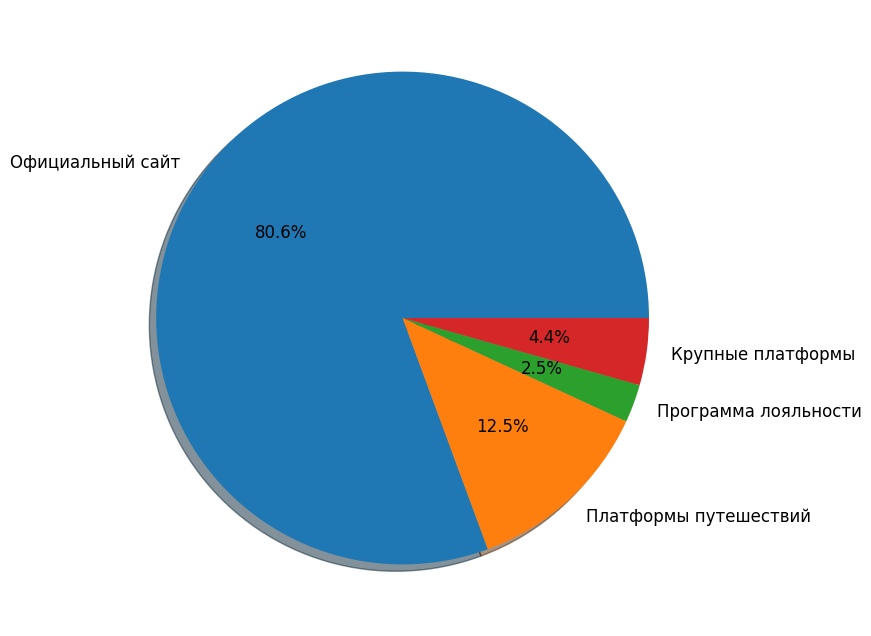

In [5]:
import matplotlib.pyplot as plt
# предположим, что у вас есть список значений для каждого сектора графика
values = [21077, 3266,652,1148]  # процент отказов на официальном сайте и на платформах типа Яндекса
labels = ['Официальный сайт', 'Платформы путешествий','Программа лояльности','Крупные платформы']

# создаем график pie
plt.figure(figsize=(10, 8))
plt.pie(values, labels=labels,shadow=True, textprops={'size': '12'}, autopct='%1.1f%%')

# отображаем график
plt.savefig("hhjgh.png")